In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.13.1+cu116


# Link Prediction on MovieLens

这个笔记展示了如何加载一组*.csv文件作为输入，并从中构建异构图。然后，我们将使用此数据集作为输入到异构图模型中，并将其用于链接预测任务。

我们将使用GroupLens研究小组收集的MovieLens数据集。这个数据集描述了MovieLens的评分和标记活动。该数据集包含来自600多个用户的9000多部电影的约10万个评分。我们将使用该数据集生成两种节点类型，分别保存电影和用户的数据，以及一种连接用户和电影的边缘类型，表示用户是否对特定电影进行了评级的关系。

然后，链接预测任务尝试预测缺失的评分，例如，可以用于向用户推荐新电影。

## 1.Heterogeneous Graph Creation

In [2]:
movies_path = './data/ml-latest-small/movies.csv'
ratings_path = './data/ml-latest-small/ratings.csv'

在创建异构图之前，让我们先来看看数据。

In [3]:
import pandas as pd

print('movies.csv:')
print('===========')
print(pd.read_csv(movies_path)[["movieId", "genres"]].head(10))
print()
print('ratings.csv:')
print('============')
print(pd.read_csv(ratings_path)[["userId", "movieId"]].head(10))

movies.csv:
   movieId                                       genres
0        1  Adventure|Animation|Children|Comedy|Fantasy
1        2                   Adventure|Children|Fantasy
2        3                               Comedy|Romance
3        4                         Comedy|Drama|Romance
4        5                                       Comedy
5        6                        Action|Crime|Thriller
6        7                               Comedy|Romance
7        8                           Adventure|Children
8        9                                       Action
9       10                    Action|Adventure|Thriller

ratings.csv:
   userId  movieId
0       1        1
1       1        3
2       1        6
3       1       47
4       1       50
5       1       70
6       1      101
7       1      110
8       1      151
9       1      157


我们可以看到`movies.csv`文件提供了两个有用的列：`movieId`为每部电影分配唯一的标识符，而`genres`列表示电影的体裁。

我们可以利用这些定义一个可以被机器学习模型轻松解释的特征表示。

In [4]:
# 将整个电影数据加载到内存中
movies_df = pd.read_csv(movies_path, index_col='movieId')

# 体裁转换为指示变量（one-hot编码）
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())

# 使用genres作为电影输入特征
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 一共20 genres

         Action  Adventure  Drama  Horror
movieId                                  
1             0          1      0       0
2             0          1      0       0
3             0          0      0       0
4             0          0      1       0
5             0          0      0       0


The `ratings.csv` data connects users (as given by `userId`) and movies (as given by `movieId`).
Due to simplicity, we do not make use of the additional `timestamp` and `rating` information.
Here, we first read the `*.csv` file from disk, and create a mapping that maps entry IDs to a consecutive value in the range `{ 0, ..., num_rows - 1 }`.
This is needed as we want our final data representation to be as compact as possible, *e.g.*, the representation of a movie in the first row should be accessible via `x[0]`.

Afterwards, we obtain the final `edge_index` representation of shape `[2, num_ratings]` from `ratings.csv` by merging mapped user and movie indices with the raw indices given by the original data frame.

In [5]:
# 将ratings data frame加载进内存
ratings_df = pd.read_csv(ratings_path)

# 创建从唯一用户索引到范围[0, num_user_nodes)的映射
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())

print()

# 创建从唯一电影索引到范围[0, num_movie_nodes)的映射
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())

# 获取user和movie的原始ID和映射ID
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)

ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)

# 构造`edge_index` in COO format
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)

print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)
print(edge_index_user_to_movie.shape)

Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        3         1
2        6         2
3       47         3
4       50         4

Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    1,    2,  ..., 3121, 1392, 2873]])
torch.Size([2, 100836])


这样，我们就可以初始化我们的`HeteroData`对象，并将必要的信息传递给它。

请注意，我们还将`node_id`向量传递给每个节点类型，以便从采样的子图中重建原始节点索引。

我们还负责向`HeteroData`对象添加反向边。这允许我们的GNN模型使用边的两个方向进行信息传递。

In [6]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()

# 保存节点索引
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))

# 添加节点特征和边索引
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie

# add the reverse edges from movies to users
# 以便使GNN能够在两个方向上传递信息
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

print(data)

assert data.node_types == ["user", "movie"]
assert data.edge_types == [("user", "rates", "movie"),
                           ("movie", "rev_rates", "user")]

assert data["user"].num_nodes == 610
assert data["user"].num_features == 0
assert data["movie"].num_nodes == 9742
assert data["movie"].num_features == 20

assert data["user", "rates", "movie"].num_edges == 100836
assert data["movie", "rev_rates", "user"].num_edges == 100836

HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={ edge_index=[2, 100836] },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)


## 2.Defining Edge-level Training Splits

Since our data is now ready-to-be-used, we can split the ratings of users into training, validation, and test splits.
This is needed in order to ensure that we leak no information about edges used during evaluation into the training phase.
For this, we make use of the [`transforms.RandomLinkSplit`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomLinkSplit) transformation from PyG.
This transforms randomly divides the edges in the `("user", "rates", "movie")` into training, validation and test edges.
The `disjoint_train_ratio` parameter further separates edges in the training split into edges used for message passing (`edge_index`) and edges used for supervision (`edge_label_index`).
Note that we also need to specify the reverse edge type `("movie", "rev_rates", "user")`.
This allows the `RandomLinkSplit` transform to drop reverse edges accordingly to not leak any information into the training phase.

In [7]:
# 训练：80%，验证：10%，测试：10%
# 训练阶段：70%的边用于消息传递；30%的边用于监督
# 负采样边比例为2
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,        # 是否为链接预测添加负训练样本。如果模型已经执行负采样，则该选项应设置为False。否则，除非再次执行负采样，否则在训练迭代中添加的负样本将是相同的。
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"), 
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)
print()
print("Testing data:")
print("================")
print(test_data)

print(train_data["user", "rates", "movie"].edge_label)
print(train_data["user", "rates", "movie"].edge_label_index)

assert train_data["user", "rates", "movie"].num_edges == 56469
assert train_data["user", "rates", "movie"].edge_label_index.size(1) == 24201
assert train_data["movie", "rev_rates", "user"].num_edges == 56469

# 没有负采样边（标签都为1）
assert train_data["user", "rates", "movie"].edge_label.min() == 1
assert train_data["user", "rates", "movie"].edge_label.max() == 1

assert val_data["user", "rates", "movie"].num_edges == 80670
assert val_data["user", "rates", "movie"].edge_label_index.size(1) == 30249
assert val_data["movie", "rev_rates", "user"].num_edges == 80670

# 负采样边比例为2
assert val_data["user", "rates", "movie"].edge_label.long().bincount().tolist() == [20166, 10083]

Training data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={
    edge_index=[2, 56469],
    edge_label=[24201],
    edge_label_index=[2, 24201],
  },
  (movie, rev_rates, user)={ edge_index=[2, 56469] }
)

Validation data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={
    edge_index=[2, 80670],
    edge_label=[30249],
    edge_label_index=[2, 30249],
  },
  (movie, rev_rates, user)={ edge_index=[2, 80670] }
)

Testing data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={
    edge_index=[2, 90753],
    edge_label=[30249],
    edge_label_index=[2, 30249],
  },
  (movie, rev_rates, user)={ edge_index=[2, 90753] }
)
tensor([1., 1., 1.,  ..., 1., 1., 1.])
tensor([[ 508,  246,  178,  ...,  199,  598,  473],
        [1993,  240,  469,  ..., 1134, 8444, 3271]])


训练边:验证边:测试边=0.8:0.1:0.1，总共100836

训练边中：消息传递:监督=0.7:0.3，训练边一共80670，其中消息边为80670 * 0.7=56469(edge_index)；监督边24201

验证边和测试边正样本（标签为1）各自为100836 * 0.1 ≈10083，由于有负采样，所以edge_label都为10083 * 3 =30249 

## 3.Defining Mini-batch Loaders

We are now ready to create a mini-batch loader that will generate subgraphs that can be used as input into our GNN.
While this step is not strictly necessary for small-scale graphs, it is absolutely necessary to apply GNNs on larger graphs that do not fit onto GPU memory otherwise.
Here, we make use of the [`loader.LinkNeighborLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.LinkNeighborLoader) which samples multiple hops from both ends of a link and creates a subgraph from it.
Here, `edge_label_index` serves as the "seed links" to start sampling from.

In [8]:
from torch_geometric.loader import LinkNeighborLoader

# 种子边
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label = train_data["user", "rates", "movie"].edge_label

# 1-hop，采样20个邻居；2-hop，采样10个邻居
# 训练阶段：负采样边:正采样边=2:1
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# 一个采样数据
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() == 0
assert sampled_data["user", "rates", "movie"].edge_label.max() == 1

Sampled mini-batch:
HeteroData(
  user={
    node_id=[606],
    n_id=[606],
  },
  movie={
    node_id=[2687],
    x=[2687, 20],
    n_id=[2687],
  },
  (user, rates, movie)={
    edge_index=[2, 16881],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[16881],
    input_id=[128],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7676],
    e_id=[7676],
  }
)


In [9]:
# 边类型
data.edge_index_dict

{('user',
  'rates',
  'movie'): tensor([[   0,    0,    0,  ...,  609,  609,  609],
         [   0,    1,    2,  ..., 3121, 1392, 2873]]),
 ('movie',
  'rev_rates',
  'user'): tensor([[   0,    1,    2,  ..., 3121, 1392, 2873],
         [   0,    0,    0,  ...,  609,  609,  609]])}

## 4.Creating a Heterogeneous Link-level GNN

We are now ready to create our heterogeneous GNN.
The GNN is responsible for learning enriched node representations from the surrounding subgraphs, which can be then used to derive edge-level predictions.
For defining our heterogenous GNN, we make use of [`nn.SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) and the [`nn.to_hetero()`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero) function, which transforms a GNN defined on homogeneous graphs to be applied on heterogeneous ones.

In addition, we define a final link-level classifier, which simply takes both node embeddings of the link we are trying to predict, and applies a dot-product on them.

As users do not have any node-level information, we choose to learn their features jointly via a `torch.nn.Embedding` layer. In order to improve the expressiveness of movie features, we do the same for movie nodes, and simply add their shallow embeddings to the pre-defined genre features.

In [10]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # 将节点嵌入转换为边表示：
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())     
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        
        # print(x_dict["user"].shape)
        # print(x_dict["movie"].shape)
        
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred
        
model = Model(hidden_channels=64)
print(model)

Model(
  (movie_lin): Linear(in_features=20, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_emb): Embedding(9742, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


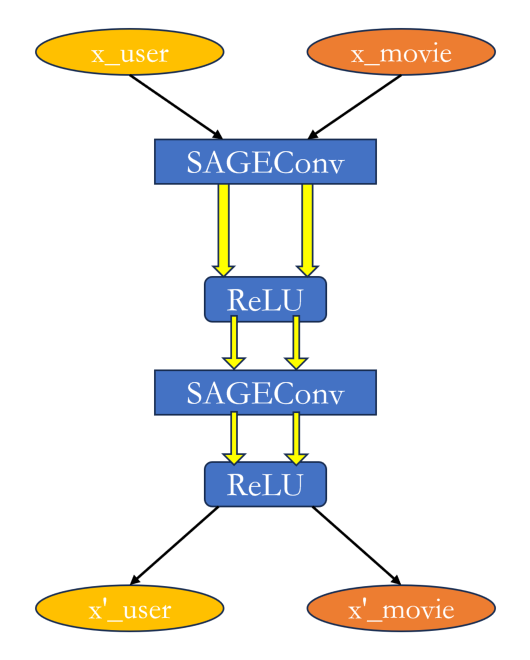

## 5.Training a Heterogeneous Link-level GNN

Training our GNN is then similar to training any PyTorch model.
We move the model to the desired device, and initialize an optimizer that takes care of adjusting model parameters via stochastic gradient descent.

The training loop then iterates over our mini-batches, applies the forward computation of the model, computes the loss from ground-truth labels and obtained predictions (here we make use of binary cross entropy), and adjusts model parameters via back-propagation and stochastic gradient descent.

In [11]:
import tqdm
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:11<00:00, 17.11it/s]


Epoch: 001, Loss: 0.4483


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:10<00:00, 18.11it/s]


Epoch: 002, Loss: 0.3516


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:10<00:00, 18.70it/s]


Epoch: 003, Loss: 0.3320


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:10<00:00, 18.95it/s]


Epoch: 004, Loss: 0.3127


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:10<00:00, 18.16it/s]

Epoch: 005, Loss: 0.2988


## 6.Evaluating a Heterogeneous Link-level GNN

After training, we evaluate our model on useen data coming from the validation set.
For this, we define a new `LinkNeighborLoader` (which now iterates over the edges in the validation set), obtain the predictions on validation edges by running the model, and finally evaluate the performance of the model by computing the AUC score over the set of predictions and their corresponding ground-truth edges (including both positive and negative edges).

In [12]:
# Define the validation seed edges:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() >= 0
assert sampled_data["user", "rates", "movie"].edge_label.max() <= 1

Sampled mini-batch:
HeteroData(
  user={
    node_id=[607],
    n_id=[607],
  },
  movie={
    node_id=[2663],
    x=[2663, 20],
    n_id=[2663],
  },
  (user, rates, movie)={
    edge_index=[2, 19034],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[19034],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7590],
    e_id=[7590],
  }
)


In [13]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print(f"Validation AUC: {auc:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 20.29it/s]

Validation AUC: 0.9307
